### Applying markov chain monte carlo to find structural breaks in the sea level rise

This notebook describes a markov chain monte carlo (MCMC) analysis with which structural breaks in the sea level trend can be discovered.

In [1]:
import numpy as np
import pymc
import matplotlib.pyplot as plt
import pymc.Matplot as mcplt

import io

import pandas as pd

# Initialize modules for the jupyter notebook format
from nbformat import current
%matplotlib inline

from collections import OrderedDict

plt.style.use('bmh')

C:\Anaconda3\lib\site-packages\nbformat\current.py:19: UserWarning: nbformat.current is deprecated.

- use nbformat for read/write/validate public API
- use nbformat.vX directly to composing notebooks of a particular version

  """)


For similar models see:

http://scrogster.wordpress.com/2011/04/05/pymc-for-bayesian-models/

http://pymc-devs.github.com/pymc/tutorial.html

### Load data

Load data from psmsl

In [2]:
def execute_notebook(nbfile):
    """Function to run other notebook in this notebook"""
    with io.open(nbfile,encoding="utf8") as f:
        nb = current.read(f, 'json')
    
    ip = get_ipython()
    
    for cell in nb.worksheets[0].cells:
        if cell.cell_type != 'code':
            continue
        ip.run_cell(cell.input)


In [3]:
execute_notebook(r'd:\Documents\GitHub\sealevel\notebooks\analysis\satellite\get-data.ipynb')

In [4]:
station_names = [
    'Vlissingen', 
    'Hoek van Holland', 
    'Den Helder', 
    'Delfzijl', 
    'Harlingen', 
    'IJmuiden'
]
# Locatie wind data is 50 km uit kust vanuit IJmuiden
rlr_data = get_station_data(dataset_name='rlr_annual', coastline_code=150, names=station_names)

found point 52.3799 3.75
rlr_annual 20 rlr
rlr_annual 22 rlr
rlr_annual 23 rlr
rlr_annual 24 rlr
rlr_annual 25 rlr
rlr_annual 32 rlr


In [5]:
stations = [20, 22, 23, 24, 25, 32]

grouped = pandas.concat(rlr_data.loc[stations, 'data'].tolist())[['year', 'height', 'u2', 'v2']].groupby(['year'])
mean_df = grouped.mean().reset_index()
# filter out non-trusted part (before NAP)
mean_df = mean_df[mean_df['year'] >= 1890]

station_names = [st.capitalize() for st in rlr_data.loc[stations, 'name'].tolist()]

print(f'Stations of which the data is used: {", ".join(station_names)}')

Stations of which the data is used: Vlissingen, Hoek van holland, Den helder, Delfzijl, Harlingen, Ijmuiden


In [6]:
mean_df.head()

,year,height,u2,v2
28,1890,-194.666667,6.287304,2.305709
29,1891,-179.000000,6.287304,2.305709
30,1892,-166.500000,6.287304,2.305709
31,1893,-142.166667,6.287304,2.305709
32,1894,-141.833333,6.287304,2.305709


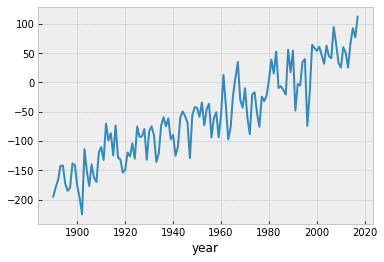

In [7]:
mean_df.set_index('year')['height'].plot()

In [8]:
t = np.asarray(mean_df['year'].values)
y = np.asarray(mean_df['height'].values)

wind_u2 = np.asarray(mean_df['u2'].values)
wind_v2 = np.asarray(mean_df['v2'].values)

y_obs = y
t=t



First step is to normalize $t$ so $t$ is 0 at the switchpoint. The new $t$ is called $t'$.

$t' = t - switchpoint$

We then define the regression equation based on the observed $y$, the constant (at $t'=0$) $b_0$, 
the trend before the switchpoint $b_1$, the trend after the switchpoint $b_2$. We use the logical expression
$t'>0$ to introduce a dummy (dichotomuous) variable that is $0$ before the switchpoint and $1$ after the switchpoint. 
By using this logical expression we only include $b2$ after the switchpoint. 


$y = b_0 + b_{1}t' + b_{2}t'(t'>0)$

In [9]:
b_trend = pymc.Normal(name='Trend', mu=0, tau=1)

b_nodalx = pymc.Uniform('Nodal U', -20, 20)
b_nodaly = pymc.Uniform('Nodal V', -20, 20)

b_windx = pymc.Uniform('Wind U^2', -20, 20)
b_windy = pymc.Uniform('Wind V^2', -20, 20)

a = pymc.Uniform(name='Constant', lower=mean_df['height'].min(), upper=mean_df['height'].max())

sigma = pymc.Uniform('Sigma', 0.0, 50) 

In [10]:
def modelled_y(a, b_trend, b_nodalx, b_nodaly, b_windx, b_windy):
    '''Compute sea level from coefficients'''
    # t70 gives the time relative to 1970 the switchpoint
    t70 = t - 1970
    
    # The trend to describe the linear sea level rise
    trend = t70 * b_trend
    
    # Nodal x, nodal y; the 18.6 year nodal cycle. Sin and cos together describe phase and amplitude
    nodalx = b_nodalx * np.cos(2*np.pi*t70/18.613)
    nodaly = b_nodaly * np.sin(2*np.pi*t70/18.613)

    # Wind components
    windx = b_windx * wind_u2
    windy = b_windy * wind_v2
    
    # Resulting sea level pattern
    out = a + trend + nodalx + nodaly + windx + windy
    return out

# Create a deterministic pymc function
@pymc.deterministic(plot=True)
def pymc_y(a=a, b_trend=b_trend, b_nodalx=b_nodalx, b_nodaly=b_nodaly, b_windx=b_windx, b_windy=b_windy):
    return modelled_y(a, b_trend, b_nodalx, b_nodaly, b_windx, b_windy)
    

Now we define the dependent variable as an observed node. 

Run the MCMC model.
iter is the number of iterations, burn is the part of the iterations we drop, thin is the 1/thin part we use. This avoides the autocorrelation which is inseperable from the MCMC model.

In [11]:
y = pymc.Normal('y', mu=pymc_y, tau=1.0/sigma**2, value=y_obs, observed=True)

M = pymc.MCMC(pymc.Model([y, a, b_trend, sigma, b_nodalx, b_nodaly, b_windx, b_windy]))
M.sample(iter=20000, burn=5000, thin=20)



 [-----------------100%-----------------] 20000 of 20000 complete in 9.6 sec

Plotting Wind U^2
Plotting Nodal V
Plotting Sigma
Plotting Nodal U
Plotting Trend
Plotting Constant
Plotting Wind V^2


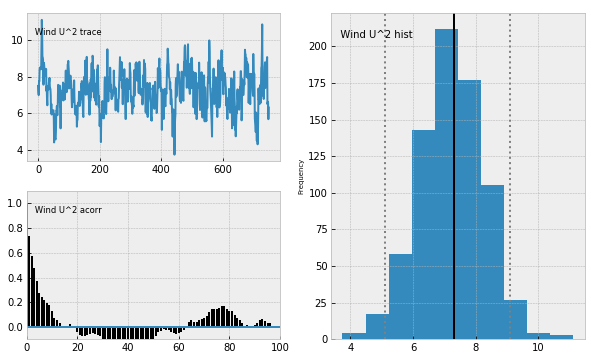

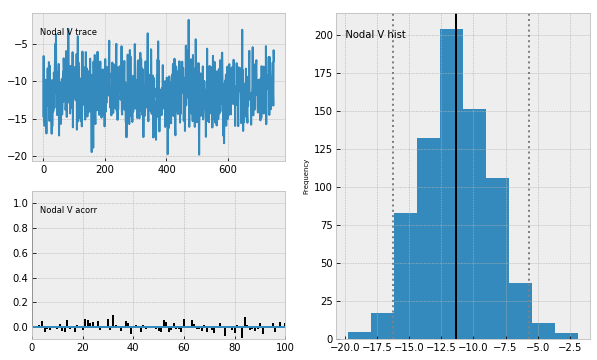

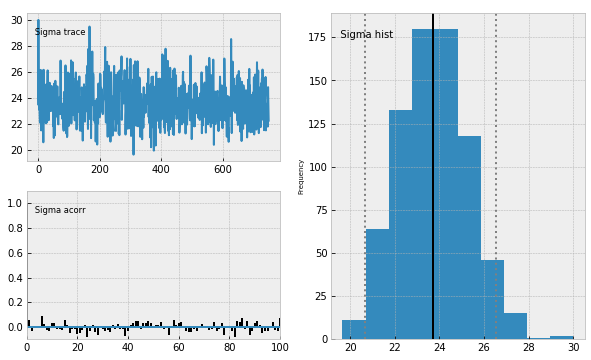

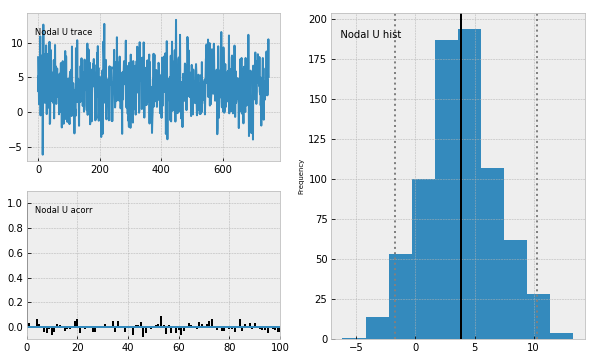

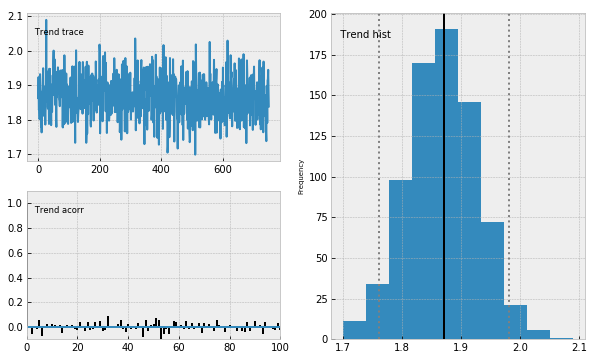

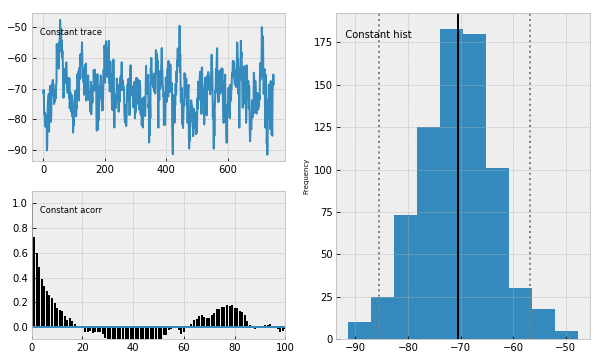

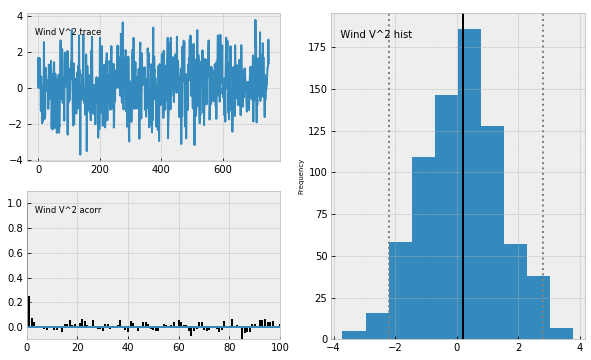

In [12]:
mcplt.plot(M)

In [13]:
# Fit the linear model
linear_fit, names = linear_model(mean_df, with_wind=True, with_season=False)
table = linear_fit.summary(yname='Sea-surface height', xname=names, title='Linear model without (1890-current)')


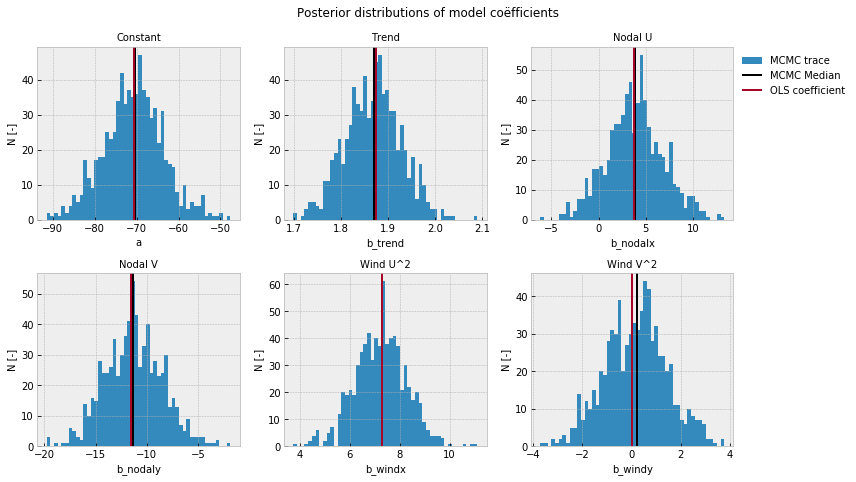

In [14]:
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(12, 7))
axs = axs.ravel()

overview = []

for i, (name, parent) in enumerate(pymc_y.parents.items()):
    
    ax = axs[i]
    
    trace = M.trace(parent.__name__)[:]
    ax.hist(trace, bins=50, label='MCMC trace')
    ax.set_title(parent.__name__, fontsize=10)
    ylim = ax.get_ylim()
    ax.set_ylim(*ylim)
    
    # Get parameters from linear model
    j = names.index(parent.__name__)
    overview.append([linear_fit.params.values[j], linear_fit.HC0_se.values[j], np.median(trace), np.std(trace)])
    
    ax.vlines([np.median(trace)], *ylim, colors=['k'], label='MCMC Median')
    ax.vlines([linear_fit.params.values[j]], *ylim, colors=['C1'], label='OLS coefficient')
    
    ax.set_xlabel(name, fontsize=10)
    ax.set_ylabel('N [-]', fontsize=10)
    
    if i == 2:
        ax.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0), framealpha=0.0)
   
fig.suptitle('Posterior distributions of model coëfficients')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    


In [15]:
overview = pd.DataFrame(
    data = overview,
    columns=pd.MultiIndex.from_product([('OLS', 'MCMC'), ('coef', 'std err')]),
    index=names
)

overview

OLS                 MCMC          
               coef   std err       coef   std err
Constant -70.662367  5.379188 -70.465684  7.152600
Trend      1.874865  0.054995   1.870807  0.059292
Nodal U    3.713045  2.863882   3.830955  3.042521
Nodal V  -11.582004  2.878221 -11.351050  2.797346
Wind U^2   7.290216  0.734160   7.291727  1.030239
Wind V^2   0.004152  1.086441   0.210825  1.274373

Text(0.5,1,'Markov-Chain Monte Carlo')

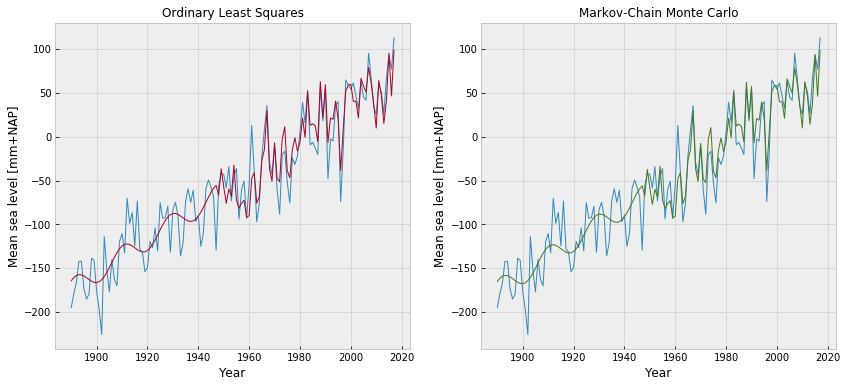

In [16]:
# Get values from model
args = {}
for name, parent in pymc_y.parents.items():
    args[name] = np.median(M.trace(parent.__name__)[:])
    
y_model = modelled_y(**args)
fig, axs = plt.subplots(ncols=2, figsize=(14, 6))

for ax in axs:
    ax.plot(t, y_obs, lw=1.0)
    ax.set_ylabel('Mean sea level [mm+NAP]')
    ax.set_xlabel('Year')

ax = axs[0]
ax.plot(t, y_model, lw=1.0)
ax.set_title('Ordinary Least Squares', fontsize=12)

ax = axs[1]
ax.plot(mean_df['year'], linear_fit.fittedvalues, lw=1.0, color='C3')
ax.set_title('Markov-Chain Monte Carlo', fontsize=12)

### Detecting Trend Breaks

In the previous analysis we saw that the MCMC method can be used to detect to find the sea level rise trend without any prior knowledge of the distributions. We use this feature to add a extra trend and switchpoint.



In [17]:
# First define two extra stochasts.
b_trend2 = pymc.Normal(name='Trend after switchpoint', mu=0, tau=1)
s = pymc.Uniform('switchpoint', lower=1900, upper=2000)


In [ ]:
def modelled_break_linear_y(a, s, b_trend, b_trend2):
    '''Compute sea level from coefficients including trend break'''
    # The trend to describe the linear sea level rise
    ts = t - s
    trend1 = ts * b_trend# * (ts < 0)
    trend2 = ts * (ts > 0) * b_trend2
    
    # Resulting sea level pattern
    out = a + trend1 + trend2
    return out

# Create a deterministic pymc function
@pymc.deterministic(plot=True)
def pymc_break_linear_y(a=a, s=s, b_trend=b_trend, b_trend2=b_trend2):
    return modelled_break_linear_y(a, s, b_trend, b_trend2)

def modelled_break_no_wind_y(a, s, b_trend, b_trend2, b_nodalx, b_nodaly):
    '''Compute sea level from coefficients including trend break'''
    out_without_nodal = modelled_break_linear_y(a, s, b_trend, b_trend2)
    
    # The trend to describe the linear sea level rise
    ts = t - s
    trend1 = ts * b_trend# * (ts < 0)
    trend2 = ts * (ts > 0) * b_trend2
    
    # Nodal x, nodal y; the 18.6 year nodal cycle. Sin and cos together describe phase and amplitude
    t70 = t - 1970
    nodalx = b_nodalx * np.cos(2*np.pi*t70/18.613)
    nodaly = b_nodaly * np.sin(2*np.pi*t70/18.613)

    # Resulting sea level pattern
    out = a + trend1 + trend2 + nodalx + nodaly
    return out

# Create a deterministic pymc function
@pymc.deterministic(plot=True)
def pymc_break_no_wind_y(a=a, s=s, b_trend=b_trend, b_trend2=b_trend2, b_nodalx=b_nodalx, b_nodaly=b_nodaly):
    return modelled_break_no_wind_y(a, s, b_trend, b_trend2, b_nodalx, b_nodaly)

def modelled_break_with_wind_y(a, s, b_trend, b_trend2, b_nodalx, b_nodaly, b_windx, b_windy):
    '''Compute sea level from coefficients including trend break with wind'''
    
    # The trend to describe the linear sea level rise
    ts = t - s
    trend1 = ts * b_trend# * (ts < 0)
    trend2 = ts * (ts > 0) * b_trend2
    
    # Nodal x, nodal y; the 18.6 year nodal cycle. Sin and cos together describe phase and amplitude
    t70 = t - 1970
    nodalx = b_nodalx * np.cos(2*np.pi*t70/18.613)
    nodaly = b_nodaly * np.sin(2*np.pi*t70/18.613)

    # Wind components
    windx = b_windx * wind_u2
    windy = b_windy * wind_v2
    
    # Resulting sea level pattern
    out = a + trend1 + trend2 + nodalx + nodaly + windx + windy
    return out

# Create a deterministic pymc function
@pymc.deterministic(plot=True)
def pymc_break_with_wind_y(a=a, s=s, b_trend=b_trend, b_trend2=b_trend2, b_nodalx=b_nodalx, b_nodaly=b_nodaly, b_windx=b_windx, b_windy=b_windy):
    return modelled_break_with_wind_y(a, s, b_trend, b_trend2, b_nodalx, b_nodaly, b_windx, b_windy)
    

In [ ]:
y = pymc.Normal('y', mu=pymc_break_linear_y, tau=1.0/sigma**2, value=y_obs, observed=True)
M_break_linear = pymc.MCMC(pymc.Model([y, a, s, b_trend, b_trend2, sigma]))
M_break_linear.sample(iter=20000, burn=5000, thin=20)

y = pymc.Normal('y', mu=pymc_break_no_wind_y, tau=1.0/sigma**2, value=y_obs, observed=True)
M_break_no_wind = pymc.MCMC(pymc.Model([y, a, s, b_trend, b_trend2, sigma, b_nodalx, b_nodaly]))
M_break_no_wind.sample(iter=20000, burn=5000, thin=20)

y = pymc.Normal('y', mu=pymc_break_with_wind_y, tau=1.0/sigma**2, value=y_obs, observed=True)
M_break_with_wind = pymc.MCMC(pymc.Model([y, a, s, b_trend, b_trend2, sigma, b_nodalx, b_nodaly, b_windx, b_windy]))
M_break_with_wind.sample(iter=20000, burn=5000, thin=20)

 [-----------------70%------            ] 14010 of 20000 complete in 18.0 sec

In [ ]:
fig, axs = plt.subplots(ncols=3, figsize=(12, 4))
axs = axs.ravel()

for i, (ax, model, name) in enumerate(zip(axs, [M_break_linear, M_break_no_wind, M_break_with_wind], ['linear', 'nodal, no wind', 'with nodal and wind'])):

    trace = model.trace('switchpoint')[:]
    ax.hist(trace, bins=50, label='MCMC trace')
    ax.set_title(f'Switchpoint {name}', fontsize=12)

    ylim = ax.get_ylim()
    ax.set_ylim(*ylim)
    ax.vlines([np.median(trace)], *ylim, colors=['k'], label='MCMC Median')
    
    ax.set_xlabel(name, fontsize=10)
    ax.set_ylabel('N [-]', fontsize=10)
    
    if i == 2:
        ax.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0), framealpha=0.0)
   
fig.suptitle('Posterior distributions of swithcpoints')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    


In [ ]:
fig, axs = plt.subplots(ncols=3, figsize=(13.5, 5))
axs = axs.ravel()

for ax in axs:

    ax.plot(t, y_obs, lw=1.0)
    ax.set_ylabel('Mean sea level [mm+NAP]')
    ax.set_xlabel('Year')
    
    ylim = ax.get_ylim()
    ax.set_ylim(*ylim)

ax = axs[0]

# Get values from model
args = {}
for name, parent in pymc_break_linear_y.parents.items():
    args[name] = np.median(M_break_linear.trace(parent.__name__)[:])
y_model = modelled_break_linear_y(**args)

ax.plot(t, y_model, lw=1.0)
ax.set_title('MCMC linear', fontsize=12)

ax.vlines([args['s']], *ylim, linestyle='--', linewidth=1.0)
ax.text(args['s']-2, ylim[0] + 0.1 * np.diff(ylim), f"before: {args['b_trend']:4.2f} mm/year", ha='right')
ax.text(args['s']+2, ylim[0] + 0.1 * np.diff(ylim), f"after: {args['b_trend2'] + args['b_trend']:4.2f} mm/year", ha='left')
ax.text(args['s']+0.1, ylim[1] - 0.05 * np.diff(ylim), f"Switchpoint = {args['s']:.0f}", rotation=-90)

ax = axs[1]

# Get values from model
args = {}
for name, parent in pymc_break_no_wind_y.parents.items():
    args[name] = np.median(M_break_no_wind.trace(parent.__name__)[:])
y_model = modelled_break_no_wind_y(**args)

ax.plot(t, y_model, lw=1.0)
ax.set_title('MCMC nodal, no wind', fontsize=12)

ax.vlines([args['s']], *ylim, linestyle='--', linewidth=1.0)
ax.text(args['s']-2, ylim[0] + 0.1 * np.diff(ylim), f"before: {args['b_trend']:4.2f} mm/year", ha='right')
ax.text(args['s']+2, ylim[0] + 0.1 * np.diff(ylim), f"after: {args['b_trend2'] + args['b_trend']:4.2f} mm/year", ha='left')
ax.text(args['s']+0.1, ylim[1] - 0.05 * np.diff(ylim), f"Switchpoint = {args['s']:.0f}", rotation=-90)

ax = axs[2]

# Get values from model
args = {}
for name, parent in pymc_break_with_wind_y.parents.items():
    args[name] = np.median(M_break_with_wind.trace(parent.__name__)[:])
y_model = modelled_break_with_wind_y(**args)

ax.plot(t, y_model, lw=1.0)
ax.set_title('MCMC with nodal and wind', fontsize=12)

ax.vlines([args['s']], *ylim, linestyle='--', linewidth=1.0)
ax.text(args['s']-2, ylim[0] + 0.1 * np.diff(ylim), f"before: {args['b_trend']:4.2f} mm/year", ha='right')
ax.text(args['s']+2, ylim[0] + 0.1 * np.diff(ylim), f"after: {args['b_trend2'] + args['b_trend']:4.2f} mm/year", ha='left')
ax.text(args['s']+0.1, ylim[1] - 0.05 * np.diff(ylim), f"Switchpoint = {args['s']:.0f}", rotation=-90)

plt.tight_layout()
